In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


In [3]:
def definir_zona(lat):
    if lat >= 25:
        return 'Norte'
    if lat < 20:
        return 'Sur'
    if 20 < lat < 25:
        return 'Centro'
    return np.nan
    
    

zonas = df.set_index('ciudad')['lat'].transform(definir_zona)
aux = df.loc[:,['ciudad']]
aux['zona'] = df['lat'].transform(definir_zona)
aux['cant'] = 1

df2 = aux.groupby(['ciudad','zona']).agg({'cant':'count'}).reset_index()
df2 = df2[df2.groupby('ciudad')['cant'].transform('max') == df2['cant']].loc[:,['ciudad','zona']].set_index('ciudad')

df = df2.merge(df, on = 'ciudad', how = 'inner')

df["fecha_publicacion"] = pd.to_datetime(df["fecha"])
df["año"] = df["fecha_publicacion"].dt.year
df["mes"] = df["fecha_publicacion"].dt.month
df['semana'] = df["fecha_publicacion"].dt.week


In [4]:
norte = df.loc[df['zona'] == 'Norte',]
centro = df.loc[df['zona'] == 'Centro',]
sur = df.loc[df['zona'] == 'Sur',]
zonas = [norte, centro, sur]

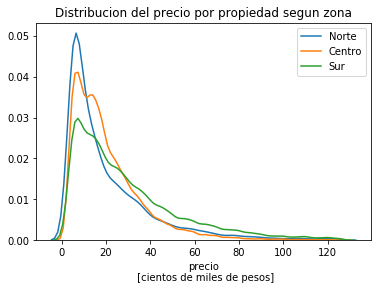

In [5]:
sns.distplot(norte['precio']/100000, hist = False, label = 'Norte')
sns.distplot(centro['precio']/100000, hist = False, label = 'Centro')
sns.distplot(sur['precio']/100000, hist = False, label = 'Sur')
plt.title('Distribucion del precio por propiedad segun zona')
plt.xlabel('precio\n [cientos de miles de pesos]')
plt.savefig('./figs/Distribucion precio zonal.png')

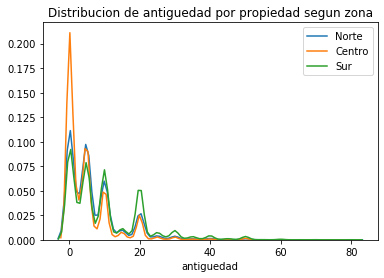

In [6]:
sns.distplot(norte['antiguedad'].dropna(), hist = False, label = 'Norte')
sns.distplot(centro['antiguedad'].dropna(), hist = False, label = 'Centro')
sns.distplot(sur['antiguedad'].dropna(), hist = False, label = 'Sur')
plt.title('Distribucion de antiguedad por propiedad segun zona')
plt.xlabel('antiguedad')
plt.savefig('./figs/Distribucion antiguedad zonal.png')

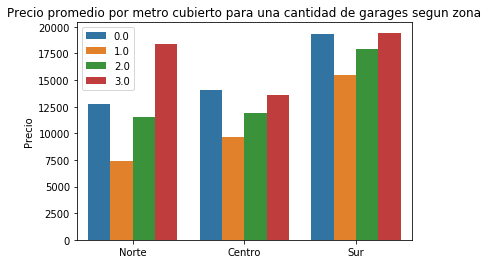

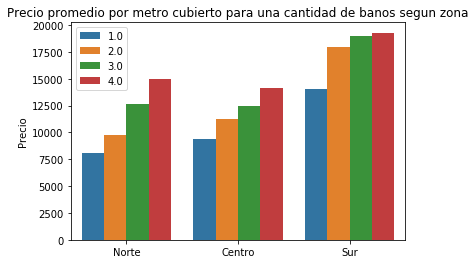

In [7]:
def barplot_para_no_bools_zonal(df, categoria):
    aux = df.groupby(['zona', categoria]).agg({'precio':'sum', 'metroscubiertos':'sum'})
    aux['promedio_precio_metro_cubierto'] = aux['precio']/aux['metroscubiertos']
    ax = sns.barplot(x = 'zona', y = 'promedio_precio_metro_cubierto', hue = categoria, order = ['Norte', 'Centro', 'Sur'], data = aux.reset_index())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.title(f'Precio promedio por metro cubierto para una cantidad de {categoria} segun zona')
    plt.xlabel('')
    plt.ylabel('Precio')
    plt.savefig(f'./figs/{categoria}-Metrocubierto-Precio barplot.jpg')

barplot_para_no_bools_zonal(df,'garages')
plt.savefig('./figs/precio garages zonal.png')
plt.show()
barplot_para_no_bools_zonal(df,'banos')
plt.savefig('./figs/precio banos zonal.png')
plt.show()

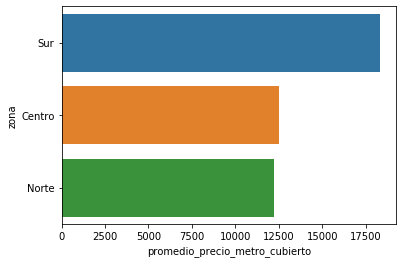

In [8]:
precio_zonal = df.groupby('zona').agg({'precio':'sum', 'metroscubiertos':'sum', 'id':'count'})
precio_zonal['promedio_precio_metro_cubierto'] = precio_zonal['precio']/precio_zonal['metroscubiertos']
sns.barplot(y = 'zona', x = 'promedio_precio_metro_cubierto', \
            data = precio_zonal.reset_index()\
                               .sort_values(by='promedio_precio_metro_cubierto', ascending = False))
plt.savefig('./figs/precio metro cubierto zonal.png')

In [9]:
df2 = df.loc[lambda x:(x['año'] != 2016) | (x['mes'] != 12),]
a = df2.groupby(['año', 'mes','zona']).agg({'id':'count'}).reset_index()#.reset_index().set_index('id')#.pivot(index = ['año','mes'], columns = 'zona',values='id')
l = [a.loc[a['zona'] == 'Norte',]['id'], a.loc[a['zona'] == 'Centro',]['id'], a.loc[a['zona'] == 'Sur',]['id']]

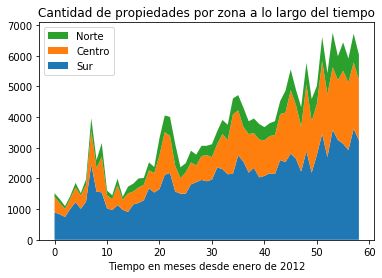

In [10]:
fig, ax = plt.subplots()
ax.stackplot(range(59), l[::-1] ,labels = a['zona'].unique())#, baseline='wiggle')
plt.title('Cantidad de propiedades por zona a lo largo del tiempo')
handles, labels = ax.get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],['Norte', 'Centro', 'Sur'], loc = 'upper left')
plt.xlabel('Tiempo en meses desde enero de 2012')
plt.savefig('./figs/Evolucion cantidad de publicaciones zonal tiempo.png')
plt.show()

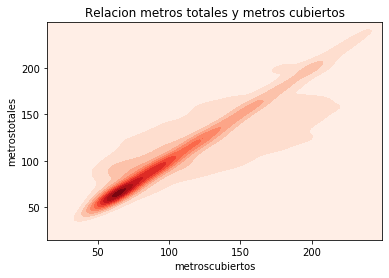

In [11]:
df2 = df.dropna(subset = ['metroscubiertos','metrostotales'])
metros = df2.loc[(df['metroscubiertos'] < 250) & (df['metrostotales'] < 250),]
#metros = df.dropna(subset = ['metroscubiertos','metrostotales'])
m_totales = metros['metrostotales']
m_cubiertos = metros['metroscubiertos']
sns.kdeplot(m_cubiertos, m_totales, cmap="Reds", shade=True, bw=.15)
plt.title('Relacion metros totales y metros cubiertos')
plt.savefig('./figs/densidad metroscubierto con metrostotales.png')